<a href="https://colab.research.google.com/github/thomasarmstrong98/thirdyearproj/blob/master/two_param_logitic_grid_approx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy.stats
import statsmodels.stats.api as sms
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from IPython.display import HTML
import math

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## ODE Model
Suppose we are given some experimental for a system which we believe follows a Logisitic/Verhust-Pearl differential equation. We do not know the growth rate $r$ or the carrying capacity of the system $K$. We wish to estimate these parameters whilst still incorporating our piror knowledge about what values $r$ and $K$ may take.

The ODE model for the system we are considering is:

$$ \frac{dN}{dt} = r \: N(1-\frac{N}{K}) $$

This equation has a closed solution which can be written as :
$$ N(t) = \frac{Ce^{r t}}{1 + \frac{C}{K}e^{r t}}, \quad C=\frac{KN(0)}{K-N(0)}$$.
In this setting we will behave as if the initial condition $N(0)$ is known and is therefore not a parameter to consider. This allows us to compute the unique solution to this ODE at any time $t$ given parameters $r$ and $K$.

## Priors and Likelihood

#### Prior

We wish to specify pior distributions for the parameters $r$ and $K$. Here, they are a priori independent, where our prior for $r$ follows an Inverse-Gamma whilst $K$ follows a normal distribution.


$$ r \sim \text{Inv-Gamma}(\mu_0, \sigma_0^2) \quad \text{and} \quad K \sim \text{Norm} ( \mu_1, \sigma_1^2) $$

#### Likelihood


We will generate some random experimental data of m observations, $\mathbf{y} = (y_1, y_2, \ldots, y_m)$ below. We assume that this data takes the value of the solution of our ODE but has been disrupted by independent zero-mean Gaussian noise with a known varance $\tau^2$. That is,

$$ y_i = N(t_i) + \epsilon_i, \quad \text{where }  \epsilon_i, ..., \epsilon_m \sim  \text{Norm} ( 0 , \tau^2) $$

Which also implies:

$$ y_i \sim \text{Norm}(N(t_i), \tau^2) $$

Therefore, conditional on the parameters $r$ and $K$ we have the likelihood function:

$$ y_i \mid r, K \sim \text{Norm}(N(t_i; r, K), \tau^2) $$
where $N(t_i; r, K)$ denotes the solution of our ODE as described in the previous section but with parameters $r$ and $K$.


In [0]:
random.seed(2019)

r = 1.2
K = 4.6
initial_N = 0.1

def initial_cond(initial_N, K):
    return (K*initial_N) / (K - initial_N) 

def diff_eqn_soln(r, K, initial_N, t):
    C = initial_cond(initial_N, K)
    return C*np.exp(r*t)/(1 + (C/K)*np.exp(r*t))

In [0]:
t = np.linspace(0,20, 51)
sol_df = pd.DataFrame(index = t)
sol_df['N'] = diff_eqn_soln(r, K, initial_N, t)

In [0]:
#Corrupting our solution with Gaussian Noise
sd = 0.3

sim_df = pd.DataFrame(index = t)
experiment = [sol + scipy.stats.norm.rvs(0, sd) for sol in sol_df['N']]
sim_df['N'] = experiment

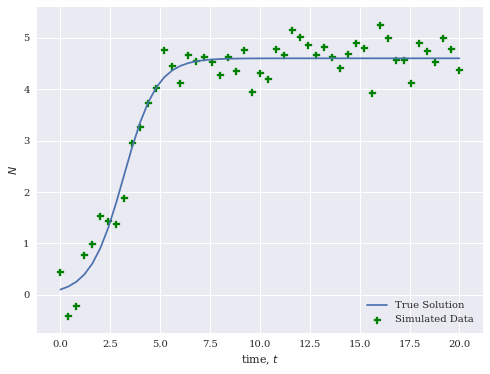

In [5]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 8
fig_size[1] = 6

plt.plot(sol_df['N'])
plt.scatter(t, sim_df['N'], color = 'g', marker = 'P')
plt.grid(True)
plt.xlabel("time, $t$")
plt.ylabel("$N$")
plt.legend(["True Solution", "Simulated Data"], loc = 'lower right')
plt.show()

In [0]:
#Defining Prior, Log-Likelihood and the Posterior

def prior(r,K):
    return scipy.stats.norm.pdf(K, 5, 2)*scipy.stats.invgamma.pdf(r,a =1, loc = 0, scale = 2)

sd = 0.3

def log_likelihood(r, K, sim_df, t, initial_N):
    lik_sum = 0
    proposed_df = pd.DataFrame(index = t)
    proposed_df['N'] = diff_eqn_soln(r, K, initial_N, t)
    for index, obs in proposed_df.iterrows():
        lik_sum = lik_sum + np.log(scipy.stats.norm.pdf(proposed_df.loc[index], sim_df.loc[index], sd))
    return lik_sum
def posterior (r, K, sim_df, t, intial_N):
    return prior(r, K)*np.exp(log_likelihood(r, K, sim_df, t, initial_N))

In [0]:
#Viewing the prior

r_grid = np.linspace(0,4, 51)
k_grid = np.linspace(1, 9, 51)

prior_mat = np.zeros((len(r_grid), len(k_grid)))
for i in range(len(r_grid)):
    for j in range(len(k_grid)):
        prior_mat[len(k_grid) - 1 - j, i] = prior(r_grid[i], k_grid[j])

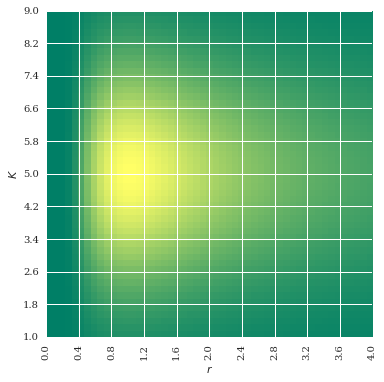

In [16]:
k_axis = []
for i in range(11):
    k_axis.append(np.round(k_grid[i*5], 2))
    
r_axis = []
for i in range(11):
    r_axis.append(np.round(r_grid[i*5],2))
    
k_axis.reverse()
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticklabels(r_axis)
plt.xticks(range(len(r_axis)), rotation = 90)
ax.set_yticklabels(k_axis)
plt.yticks(range(len(k_axis)))
ax.xaxis.set_major_locator(plt.LinearLocator(11))
ax.yaxis.set_major_locator(plt.LinearLocator(11))

plt.imshow(prior_mat, cmap = cm.summer)
plt.xlabel('$r$')
plt.ylabel('$K$')
plt.show()

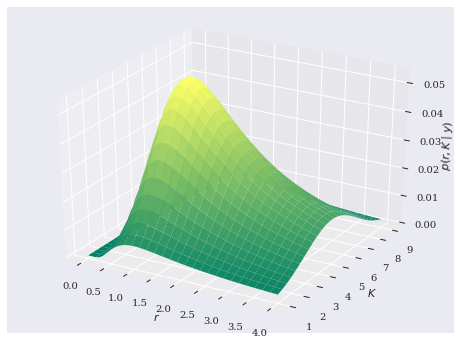

In [11]:
x, y = np.meshgrid(r_grid, k_grid)
fig = plt.figure()

ax = fig.gca(projection='3d')


surf = ax.plot_surface(x, y, prior_mat, cmap=cm.summer,linewidth=0, antialiased=True)
ax.set_xlabel('$r$')
ax.set_ylabel('$K$')
ax.set_zlabel('$p(r, K \mid y)$')

plt.show()

In [0]:
#Calcualting the un-normalised posterior

post_mat = np.zeros((len(r_grid), len(k_grid)))

for i in range(len(r_grid)):
    for j in range(len(k_grid)):
        post_mat[len(k_grid) - j - 1, i] = posterior(r_grid[i], k_grid[j], sim_df, t, initial_N)

In [13]:
post_mat = np.nan_to_num(post_mat)
post_mat.sum()

5.683967184033555e-09

In [0]:
#Normalising the posterior by approximating the evidence term of Bayes Rule

post_mat = post_mat / (post_mat.sum() * (r_grid[1] - r_grid[0]) * (k_grid[1] - k_grid[0]))

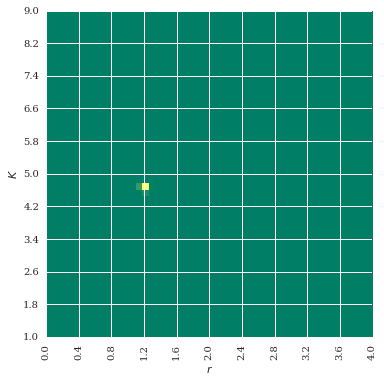

In [17]:
k_axis = []
for i in range(11):
    k_axis.append(np.round(k_grid[i*5], 2))
    
r_axis = []
for i in range(11):
    r_axis.append(np.round(r_grid[i*5],2))
    
k_axis.reverse()
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticklabels(r_axis)
plt.xticks(range(len(r_axis)), rotation = 90)
ax.set_yticklabels(k_axis)
plt.yticks(range(len(k_axis)))
ax.xaxis.set_major_locator(plt.LinearLocator(11))
ax.yaxis.set_major_locator(plt.LinearLocator(11))

plt.imshow(post_mat, cmap = cm.summer)
plt.xlabel('$r$')
plt.ylabel('$K$')
plt.show()

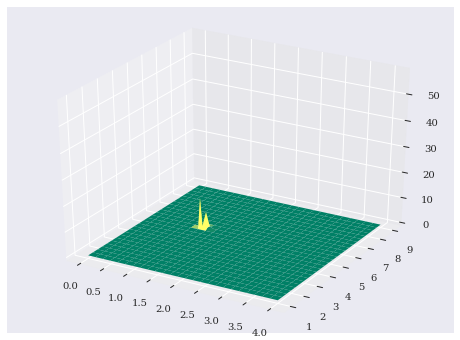

In [18]:
x, y = np.meshgrid(r_grid, k_grid)
fig = plt.figure()

ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, post_mat, cmap=cm.summer,linewidth=0, antialiased=True)

In [0]:
#Refining our grid so that we can observe the peak more clearly

r_grid = np.linspace(1,2, 51)
k_grid = np.linspace(4, 6, 51)


#Rerun our Algorithm as before


post_mat = np.zeros((len(r_grid), len(k_grid)))

for i in range(len(r_grid)):
    for j in range(len(k_grid)):
        post_mat[len(k_grid) - j - 1, i] = posterior(r_grid[i], k_grid[j], sim_df, t, initial_N)


In [0]:
post_mat = np.nan_to_num(post_mat)

#Normalising the posterior by approximating the evidence term of Bayes Rule

post_mat = post_mat / (post_mat.sum() * (r_grid[1] - r_grid[0]) * (k_grid[1] - k_grid[0]))

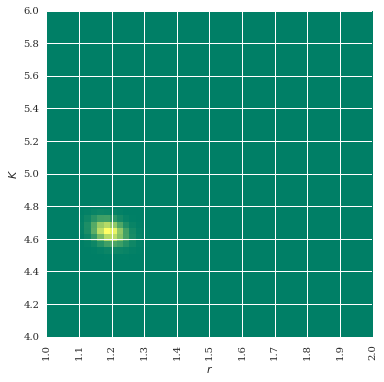

In [21]:
k_axis = []
for i in range(11):
    k_axis.append(np.round(k_grid[i*5], 2))
    
r_axis = []
for i in range(11):
    r_axis.append(np.round(r_grid[i*5],2))

k_axis.reverse()
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticklabels(r_axis)
plt.xticks(range(len(r_axis)), rotation = 90)
ax.set_yticklabels(k_axis)
plt.yticks(range(len(k_axis)))
ax.xaxis.set_major_locator(plt.LinearLocator(11))
ax.yaxis.set_major_locator(plt.LinearLocator(11))


plt.imshow(post_mat, cmap = cm.summer)
plt.xlabel('$r$')
plt.ylabel('$K$')
plt.show()

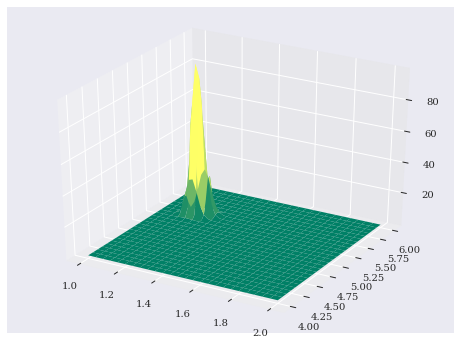

In [22]:
x, y = np.meshgrid(r_grid, k_grid)
fig = plt.figure()

ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, post_mat, cmap=cm.summer,linewidth=0, antialiased=True)

In [0]:
#Refining once more


r_grid = np.linspace(0.9,1.5, 51)
k_grid = np.linspace(4.3, 4.9, 51)


#Rerun our Algorithm as before


post_mat = np.zeros((len(r_grid), len(k_grid)))

for i in range(len(r_grid)):
    for j in range(len(k_grid)):
        post_mat[len(r_grid) - j - 1, i] = posterior(r_grid[i], k_grid[j], sim_df, t, initial_N)
        

post_mat = np.nan_to_num(post_mat)

#Normalising the posterior by approximating the evidence term of Bayes Rule

post_mat = post_mat / (post_mat.sum() * (r_grid[1] - r_grid[0]) * (k_grid[1] - k_grid[0]))

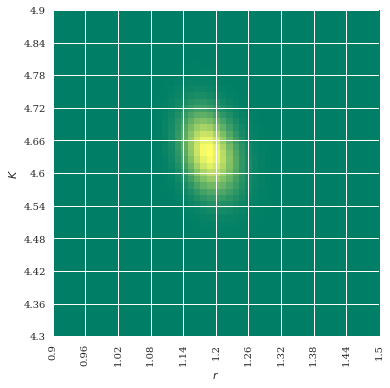

In [30]:
k_axis = []
for i in range(11):
    k_axis.append(np.round(k_grid[i*5], 2))
    
r_axis = []
for i in range(11):
    r_axis.append(np.round(r_grid[i*5],2))
    
k_axis.reverse()
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticklabels(r_axis)
plt.xticks(range(len(r_axis)), rotation = 90)
ax.set_yticklabels(k_axis)
plt.yticks(range(len(k_axis)))
ax.xaxis.set_major_locator(plt.LinearLocator(11))
ax.yaxis.set_major_locator(plt.LinearLocator(11))


plt.imshow(post_mat, cmap = cm.summer)
plt.xlabel('$r$')
plt.ylabel('$K$')
plt.show()

Text(0.5, 0, '$p(r, K \\mid y)$')

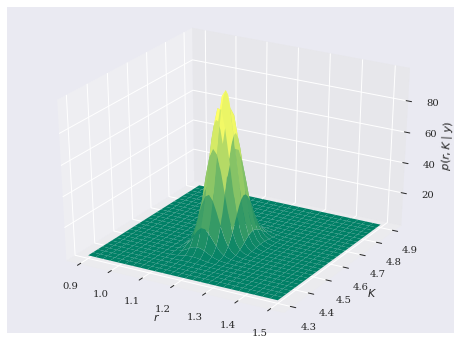

In [32]:
x, y = np.meshgrid(r_grid, k_grid)
fig = plt.figure()

ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, post_mat, cmap=cm.summer,linewidth=0, antialiased=True)
ax.set_xlabel('$r$')
ax.set_ylabel('$K$')
ax.set_zlabel('$p(r, K \mid y)$')